In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import pickle
from kepler_func import *
from IPython.core.display import display, HTML

display(HTML('''
<style>
.output_scroll {
    overflow-x: auto !important;
    overflow-y: visible !important;
    max-height: none !important;
}
</style>
'''))

%matplotlib inline


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


Mercury
Venus
Earth
Mars


100000
100001
100002
100003
100004
100005
100006
100007
100008


100009
100010
100011
100012
100013
100014
100015
100016


100017
100018
100019
100020
100021
100022
100023
100024


100025
100026
100027
100028
100029
100030
100031
100032


100033
100034
100035
100036
100037
100038
100039
100040
100041


100042
100043
100044
100045
100046
100047
100048
100049


100050
100051
100052
100053
100054
100055
100056
100057
100058


100059
100060
100061
100062
100063
100064
100065
100066


100067
100068
100069
100070
100071
100072
100073
100074


100075
100076
100077
100078
100079
100080
100081
100082
100083


100084
100085
100086
100087
100088
100089
100090
100091


100092
100093
100094
100095
100096
100097
100098
100099


100100
100101
100102
100103
100104
100105
100106
100107


100108
100109
100110
100111
100112
100113
100114
100115


100116
100117
100118
100119
100120
100121
100122
100123


100124
100125
100126
100127
100128
100129
100130
100131


100132
100133
100134
100135
100136
100137


100138
100139
100140
100141
100142
100143
100144
100145


100146
100147
100148
100149
100150
100151
100152
100153


100154
100155
100156
100157
100158
100159
100160
100161


100162
100163
100164
100165
100166
100167
100168
100169


100170
100171
100172
100173
100174
100175
100176
100177


100178
100179
100180
100181
100182
100183
100184
100185


100186
100187
100188
100189
100190
100191


100192
100193
100194
100195
100196
100197
100198
100199


100200
100201
100202
100203
100204
100205
100206
100207


100208
100209
100210
100211
100212
100213
100214
100215


100216
100217
100218
100219
100220
100221
100222
100223


100224
100225
100226
100227
100228
100229
100230
100231


100232
100233
100234
100235
100236
100237


100238
100239
100240
100241
100242
100243
100244
100245


100246
100247
100248
100249
100250
100251
100252
100253


100254
100255
100256
100257
100258
100259
100260
100261


100262
100263
100264
100265
100266
100267
100268
100269


100270
100271
100272
100273
100274
100275


100276
100277
100278
100279
100280
100281
100282
100283


100284
100285
100286
100287
100288
100289
100290
100291


100292
100293
100294
100295
100296
100297
100298
100299


100300
100301
100302
100303
100304
100305
100306
100307
100308


100309
100310
100311
100312
100313
100314
100315
100316


100317
100318
100319
100320
100321
100322
100323
100324


100325
100326
100327
100328
100329
100330
100331


100332
100333
100334
100335
100336
100337
100338
100339


100340
100341
100342
100343
100344
100345
100346
100347


100348
100349
100350
100351
100352
100353
100354
100355


100356
100357
100358
100359
100360
100361
100362
100363


100364
100365
100366
100367
100368
100369
100370
100371


100372
100373
100374
100375
100376
100377


100378
100379
100380
100381
100382
100383
100384
100385


100386
100387
100388
100389
100390
100391
100392
100393


100394
100395
100396
100397
100398
100399
100400
100401


100402
100403
100404
100405
100406
100407
100408
100409


100410
100411
100412
100413
100414
100415
100416


100417
100418
100419
100420
100421
100422
100423
100424


100425
100426
100427
100428
100429
100430
100431
100432


100433
100434
100435
100436
100437
100438
100439
100440


100441
100442
100443
100444
100445
100446
100447
100448


100449
100450
100451
100452
100453
100454
100455
100456


100457
100458
100459
100460
100461
100462
100463
100464


100465
100466
100467
100468
100469
100470
100471
100472


100473
100474
100475
100476
100477
100478


100479
100480
100481
100482
100483
100484
100485
100486


100487
100488
100489
100490
100491
100492
100493
100494


100495
100496
100497
100498
100499
199
299
399


499
599
699
799
899
999
2000001
2000002
Failed to fetch data for target 2000002: Query failed without known error message; received the following response:
API VERSION: 1.2
API SOURCE: NASA/JPL Horizons API

DXREAD: requested IOBJ=  2000002 is out of bounds, no action taken.
Record boundaries:                                                 
 IAU numbered asteroids:        1-  811552                         
 Unnumbered asteroids  : 50000001-50643801                         
 Comets                : 90000001-90004915                         
If an SPK ID, look-up with "DES=  2000002;"                        

2000004
2000433


Failed to fetch data for target 2000433: Horizons Error: No ephemeris for target "" after A.D. 2009-DEC-31 00:00:00.0000 TD
2025143
Failed to fetch data for target 2025143: Query failed without known error message; received the following response:
API VERSION: 1.2
API SOURCE: NASA/JPL Horizons API

DXREAD: requested IOBJ=  2025143 is out of bounds, no action taken.
Record boundaries:                                                 
 IAU numbered asteroids:        1-  811552                         
 Unnumbered asteroids  : 50000001-50643801                         
 Comets                : 90000001-90004915                         
If an SPK ID, look-up with "DES=  2025143;"                        

1000001
Failed to fetch data for target 1000001: Query failed without known error message; received the following response:
API VERSION: 1.2
API SOURCE: NASA/JPL Horizons API

DXREAD: requested IOBJ=  1000001 is out of bounds, no action taken.
Record boundaries:                             

/var/folders/d2/967f_3k57458fwy_1s1dh8_w0000gn/T/ipykernel_94668/1737583335.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


Get some data from NASA Horizons

Mercury
Venus
Earth
Mars
100000
100001
100002
100003
100004
100005
100006
100007
100008


100009
100010
100011
100012
100013
100014
100015
100016


100017
100018
100019
100020
100021
100022
100023
100024


100025
100026
100027
100028
100029
100030
100031
100032


100033
100034
100035
100036
100037
100038
100039
100040


100041
100042
100043
100044
100045
100046
100047
100048


100049
100050
100051
100052
100053
100054
100055
100056


100057
100058
100059
100060
100061
100062
100063
100064
100065


100066
100067
100068
100069
100070
100071
100072
100073


100074
100075
100076
100077
100078
100079
100080
100081


100082
100083
100084
100085
100086
100087
100088
100089


100090
100091
100092
100093
100094
100095
100096
100097


100098
100099
100100
100101
100102
100103
100104
100105


100106
100107
100108
100109
100110
100111
100112
100113


100114
100115
100116
100117
100118
100119
100120
100121


100122
100123
100124
100125
100126
100127
100128
100129


100130
100131
100132
100133
100134
100135
100136
100137


100138
100139
100140
100141
100142
100143
100144
100145


100146
100147
100148
100149
100150
100151


100152
100153
100154
100155
100156
100157
100158
100159
100160


100161
100162
100163
100164
100165
100166
100167
100168


100169
100170
100171
100172
100173
100174
100175
100176


100177
100178
100179
100180
100181
100182
100183
100184


100185
100186
100187
100188
100189
100190


100191
100192
100193
100194
100195
100196
100197
100198


100199
100200
100201
100202
100203
100204
100205
100206


100207
100208
100209
100210
100211
100212
100213
100214


100215
100216
100217
100218
100219
100220
100221
100222


100223
100224
100225
100226
100227
100228
100229
100230


100231
100232
100233
100234
100235
100236
100237
100238
100239


100240
100241
100242
100243
100244
100245
100246
100247


100248
100249
100250
100251
100252
100253


100254
100255
100256
100257
100258
100259
100260
100261


100262
100263
100264
100265
100266
100267
100268
100269


100270
100271
100272
100273
100274
100275
100276
100277


100278
100279
100280
100281
100282
100283
100284
100285
100286


100287
100288
100289
100290
100291
100292
100293
100294


100295
100296
100297
100298
100299
100300
100301
100302


100303
100304
100305
100306
100307
100308
100309
100310
100311


100312
100313
100314
100315
100316
100317
100318
100319


100320
100321
100322
100323
100324
100325
100326
100327


100328
100329
100330
100331
100332
100333


100334
100335
100336
100337
100338
100339
100340
100341


100342
100343
100344
100345
100346
100347
100348
100349


100350
100351
100352
100353
100354
100355
100356
100357


100358
100359
100360
100361
100362
100363
100364
100365


100366
100367
100368
100369
100370
100371
100372
100373


100374
100375
100376
100377
100378
100379
100380
100381


100382
100383
100384
100385
100386
100387
100388
100389


100390
100391
100392
100393
100394
100395
100396
100397
100398


100399
100400
100401
100402
100403
100404
100405
100406
100407


100408
100409
100410
100411
100412
100413
100414
100415


100416
100417
100418
100419
100420
100421
100422
100423


100424
100425
100426
100427
100428
100429
100430
100431


100432
100433
100434
100435
100436
100437


100438
100439
100440
100441
100442
100443
100444
100445
100446


100447
100448
100449
100450
100451
100452
100453
100454


100455
100456
100457
100458
100459
100460
100461
100462


100463
100464
100465
100466
100467
100468
100469
100470


100471
100472
100473
100474
100475
100476


100477
100478
100479
100480
100481
100482
100483
100484


100485
100486
100487
100488
100489
100490
100491
100492


100493
100494
100495
100496
100497
100498
100499
199
299


399
499
599
699
799
899
999
2000001


2000002
Failed to fetch data for target 2000002: Query failed without known error message; received the following response:
API VERSION: 1.2
API SOURCE: NASA/JPL Horizons API

DXREAD: requested IOBJ=  2000002 is out of bounds, no action taken.
Record boundaries:                                                 
 IAU numbered asteroids:        1-  811552                         
 Unnumbered asteroids  : 50000001-50643801                         
 Comets                : 90000001-90004915                         
If an SPK ID, look-up with "DES=  2000002;"                        

2000004
2000433
Failed to fetch data for target 2000433: Horizons Error: No ephemeris for target "" after A.D. 2009-DEC-31 00:00:00.0000 TD
2025143
Failed to fetch data for target 2025143: Query failed without known error message; received the following response:
API VERSION: 1.2
API SOURCE: NASA/JPL Horizons API

DXREAD: requested IOBJ=  2025143 is out of bounds, no action taken.
Record boundaries:             

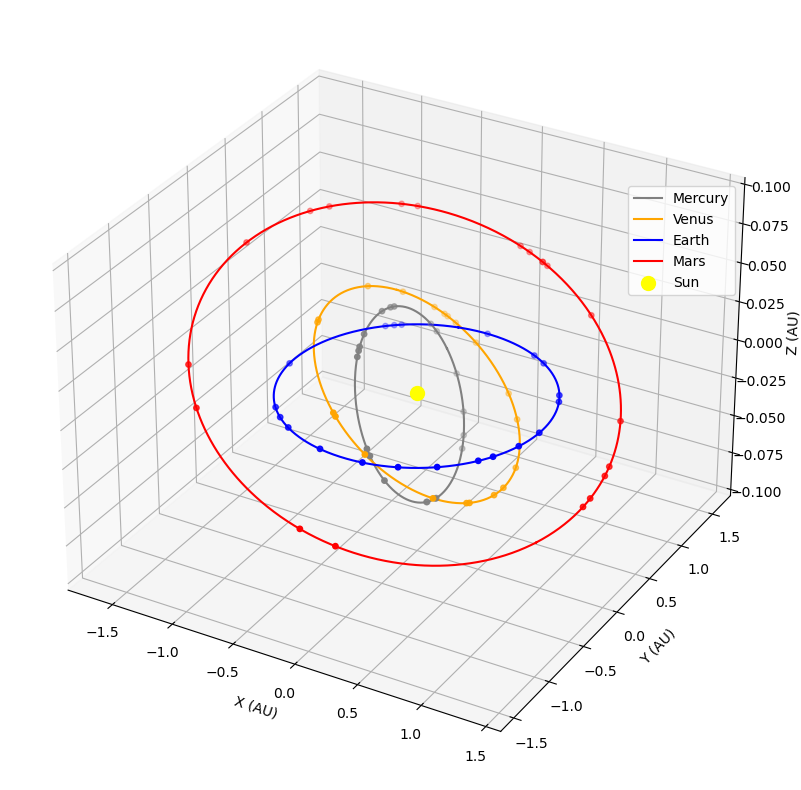

In [2]:
# Define planet IDs
planets = {
    'Mercury': 199,
    'Venus': 299,
    'Earth': 399,
    'Mars': 499
}

colors = {
        'Mercury': 'gray',
        'Venus': 'orange',
        'Earth': 'blue',
        'Mars': 'red'
    }

# Define epoch for orbital elements (Julian Date for 2021-Jan-01)
epoch = {'start': '2008-01-06', 'stop': '2009-01-06', 'step': '30d'}
# Define observation time range
obs_epochs = {'start': '1993-01-01', 'stop': '2023-01-01', 'step': '30d'}

if os.path.exists('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/NASA_data.pkl'):
    dataset = pickle.load(open('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/NASA_data.pkl', 'rb'))
    orbitalObs_df, orbitalParams_df, true_anomaly_values_df, multi_orbitalParams_df, multi_orbitalObs_df = dataset
else:
    orbitalObs_df, orbitalParams_df, true_anomaly_values_df, multi_orbitalParams_df, multi_orbitalObs_df = get_orbital_observations(planets, epoch, obs_epochs)
    with open('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/NASA_data.pkl', 'wb') as file:
            pickle.dump([orbitalObs_df, orbitalParams_df, true_anomaly_values_df, multi_orbitalParams_df, multi_orbitalObs_df], file)

#print(true_anomaly_values_df.head())
#print(orbitalParams_df.head())
#print(orbitalObs_df.head())

In [ ]:
indices = [0,1,-2,-1]
opdf = multi_orbitalParams_df[['a','e','M','T']]
observations2IRAS = np.log(opdf.to_numpy()[None])
observations_tVec = np.repeat(np.arange(observations2IRAS.shape[1])[None,:,None], observations2IRAS.shape[0], 0) 
hypotheses_regulations = None

observations_noisy = observations2IRAS
for featureIdx in range(observations_noisy.shape[2]):
    std = observations2IRAS[:,:,featureIdx].flatten().std()
    observations_noisy[:,:,featureIdx] = observations2IRAS[:,:,featureIdx] + 1e-2*std*np.random.randn(observations2IRAS.shape[0], observations2IRAS.shape[1])
#hypotheses_regulations_pearson = (np.power(observations_noisy[:,:,-1], 2) - np.power(observations_noisy[:,:,0], 3))[:,:,None]
hypotheses_regulations_pearson = [(2*observations_noisy[:,:,-1] / 3*observations_noisy[:,:,0])[:,:,None], (2*observations_noisy[:,:,-1] - 3*observations_noisy[:,:,0])[:,:,None]]
hypotheses_regulations_pearson = hypotheses_regulations_pearson[1]#np.stack([hypotheses_regulations_pearson[0], hypotheses_regulations_pearson[1]], axis=0)
#plt.figure()
#plt.scatter(x=np.power(observations_noisy[:,:,0],3),y=np.power(observations_noisy[:,:,-1],2))

#plt.figure()
#plt.scatter(x=np.power(observations_noisy[:,:,0],1),y=np.power(observations_noisy[:,:,-1],1))

In [ ]:
IRAS_runOnCoordinatesResultsDict = pickle.load(open('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/IRAS_results.pkl', 'rb'))
enable_IRAStrain = True
if enable_IRAStrain:
    nIRAS_iter=10
    min_CR_naive = np.inf
    for i in range(nIRAS_iter):
        implicitPolyDictList = IRAS_train_script(observations2IRAS, observations_tVec, hypotheses_regulations, seriesForPearson=observations_noisy, hypothesesForPearson=hypotheses_regulations_pearson, titleStr='', nativeIRAS=True, nEpochs=500, degreeOfPolyFit=[1], onlyPolyMixTerms=False, externalReport=True, features2ShuffleTogether=None, playerPerPatient=False)
        if implicitPolyDictList[0]['CR_zeta1'] < min_CR_naive:
                minCR_implicitPolyDictList = implicitPolyDictList
                min_CR_naive = implicitPolyDictList[0]['CR_zeta1']
    
    IRAS_runOnCoordinatesResultsDict['k3'] = {'planet': '', 'observations2IRAS': observations2IRAS, 'degreeOfPolyFit': [1], 'implicitPolyDictList': minCR_implicitPolyDictList}
    with open('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/IRAS_results.pkl', 'wb') as file:
            pickle.dump(IRAS_runOnCoordinatesResultsDict, file)

In [ ]:

print_IRAS_res(IRAS_runOnCoordinatesResultsDict['k3'], 0)


In [3]:
IRAS_runOnCoordinatesResultsDict['k3'].keys()

NameError: name 'IRAS_runOnCoordinatesResultsDict' is not defined

In [3]:
# Initialize plot
#different_plots(planets, true_anomaly_values_df, orbitalObs_df)

In [4]:
# plot planets before and after transformation to Perifocal frame:
#perifocal_trans_plot(planets, orbitalObs_df, orbitalParams_df)

Run IRAS on Mercury coordinates:

In [5]:
enableIRAS_train = False
if enableIRAS_train:
    IRAS_runOnCoordinatesResultsDict = dict()
    IRAS_runOnCoordinatesResultsDict['Mercury'] = runIRAS('Mercury', true_anomaly_values_df, orbitalObs_df, orbitalParams_df)
    
    
    with open('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/IRAS_results.pkl', 'wb') as file:
        pickle.dump(IRAS_runOnCoordinatesResultsDict, file)


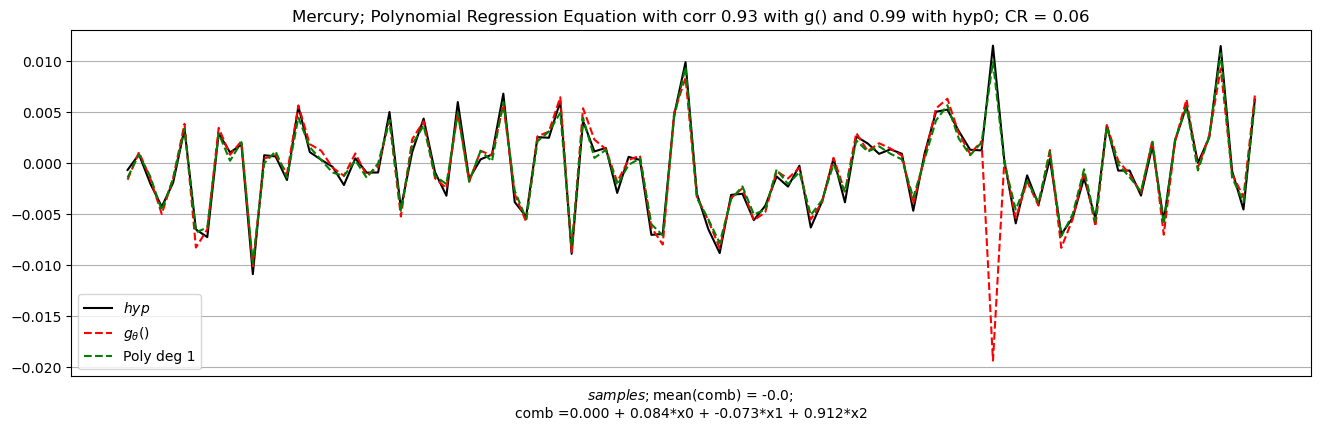

Mercury; GT plane eq: 0=0.000 + 0.091*x + -0.081*y + 0.993*z; IRAS-polyFit eq: 0=0.001 + 0.092*x + -0.079*y + 0.993*z; angle between normals is 0.1292 deg
sanity orbital plane eq: 0=[ 0.          0.09108063 -0.08108878  0.99253661]


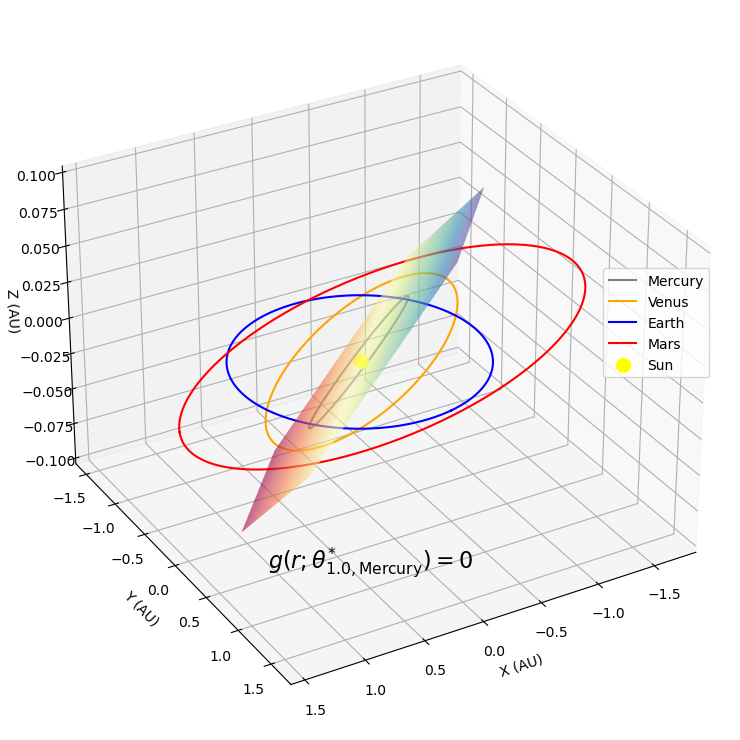

In [6]:
IRAS_runOnCoordinatesResultsDict = pickle.load(open('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/IRAS_results.pkl', 'rb'))

highScoreHyp = get_highScoreHyp(IRAS_runOnCoordinatesResultsDict['Mercury'])
print_IRAS_res(IRAS_runOnCoordinatesResultsDict['Mercury'], highScoreHyp)
plot_manifold(IRAS_runOnCoordinatesResultsDict['Mercury'], highScoreHyp, true_anomaly_values_df, orbitalObs_df, orbitalParams_df, title3D=r'$g(r;\theta^{*}_{1.0,\mathrm{Mercury}})=0$')

In [7]:
alpha = 1e-2
orbitalParams_df['est_orbitalPlaneNormal'] = orbitalParams_df.apply(lambda row: add_est_orbitalPlaneNormal(row, 'Mercury', IRAS_runOnCoordinatesResultsDict['Mercury']['implicitPolyDictList'][0]['coefficients'][1:][:,None], 'est_orbitalPlaneNormal'), axis=1)
orbitalObs_df['r_proj2EstOrbitalPlane'] = orbitalObs_df.apply(lambda row: proj_r_2EstOrbitalPlane(row, orbitalParams_df), axis=1)
orbitalObs_df['r_2D_est'] = orbitalObs_df.apply(lambda row: transform_2_2D(row, orbitalParams_df, np.array([[1], [0], [0]]), est=True), axis=1)
orbitalObs_df['r_2D_est_noisy'] = orbitalObs_df.apply(lambda row: convert_to_r(row, orbitalObs_df, orbitalParams_df, alpha, workOn2D_est=True, est=True), axis=1)


orbitalObs_df['v_proj2EstOrbitalPlane'] = orbitalObs_df.apply(lambda row: proj_r_2EstOrbitalPlane(row, orbitalParams_df, to_v=True), axis=1)
orbitalObs_df['v_2D_est'] = orbitalObs_df.apply(lambda row: transform_2_2D(row, orbitalParams_df, np.array([[1], [0], [0]]), est=True, to_v=True), axis=1)
orbitalObs_df['v_2D_est_noisy'] = orbitalObs_df.apply(lambda row: convert_to_r(row, orbitalObs_df, orbitalParams_df, alpha, workOn2D_est=True, to_v=True, est=True), axis=1)
orbitalObs_df['L_2D_est'] = orbitalObs_df.apply(lambda row: calc_L(row, twoD=True, est=True), axis=1)
orbitalObs_df['L_2D_est_noisy'] = orbitalObs_df.apply(lambda row: calc_L(row, twoD=True, est=True, noisy=True), axis=1)

/Users/ron.teichner/Projects/IRAS/kepler_func.py:415: RuntimeWarning: invalid value encountered in divide
  return r - (n.T@r / np.power(np.linalg.norm(n), 2)) * n
/Users/ron.teichner/Projects/IRAS/kepler_func.py:325: RuntimeWarning: invalid value encountered in divide
  u = (np.cross(normal[:,0],a[:,0]) / np.linalg.norm(np.cross(normal[:,0],a[:,0])))[:,None]
/Users/ron.teichner/Projects/IRAS/kepler_func.py:415: RuntimeWarning: invalid value encountered in divide
  return r - (n.T@r / np.power(np.linalg.norm(n), 2)) * n
/Users/ron.teichner/Projects/IRAS/kepler_func.py:325: RuntimeWarning: invalid value encountered in divide
  u = (np.cross(normal[:,0],a[:,0]) / np.linalg.norm(np.cross(normal[:,0],a[:,0])))[:,None]


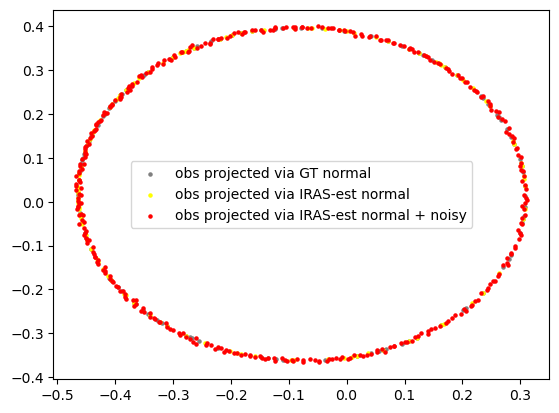

In [8]:
Obs = orbitalObs_df[orbitalObs_df['target'] == 'Mercury']

alpha = np.asarray([Obs['r_2D'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
beta = np.asarray([Obs['r_2D'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])

alpha_hat = np.asarray([Obs['r_2D_est'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
beta_hat = np.asarray([Obs['r_2D_est'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])

alpha_hat_noisy = np.asarray([Obs['r_2D_est_noisy'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
beta_hat_noisy = np.asarray([Obs['r_2D_est_noisy'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])

plt.figure()
indices = np.random.permutation(np.arange(len(alpha_hat)))[:int(0.3*len(alpha_hat))]
plt.scatter(x=alpha[indices], y=beta[indices], s=5, color=colors['Mercury'], label='obs projected via GT normal')
indices = np.random.permutation(np.arange(len(alpha_hat)))[:int(0.3*len(alpha_hat))]
plt.scatter(x=alpha_hat[indices], y=beta_hat[indices], s=5, color='yellow', label='obs projected via IRAS-est normal')
indices = np.random.permutation(np.arange(len(alpha_hat)))
plt.scatter(x=alpha_hat_noisy[indices], y=beta_hat_noisy[indices], s=5, color='red', label='obs projected via IRAS-est normal + noisy')
plt.legend()
plt.show()

In [9]:
enableIRAS_train = False
if enableIRAS_train:
    IRAS_runOnCoordinatesResultsDict['Mercury2D'] = runIRAS('Mercury', true_anomaly_values_df, orbitalObs_df, orbitalParams_df, runOn2D=True, externalReport=True)


with open('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/IRAS_results.pkl', 'wb') as file:
    pickle.dump(IRAS_runOnCoordinatesResultsDict, file)


In [10]:
IRAS_runOnCoordinatesResultsDict = pickle.load(open('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/IRAS_results.pkl', 'rb'))
IRAS_runOnCoordinatesResultsDict['Mercury2D']['implicitPolyDictList'][0]['ellipse_fit']



{'ellipse_eq': '6.6879(x - -0.0776)² + 0.1267(x - -0.0776)(y - 0.0175) + 6.9539(y - 0.0175)²',
 'corr': -0.9922929012222913,
 'ellipse_params': {'A': 6.687902514371235,
  'B': 0.12665375617568428,
  'C': 6.95387640207804,
  'h': -0.07764258071929922,
  'k': 0.017545304034481596},
 'ellipse_rot_angle': -0.22220887542672876,
 'axes_eccentricity': {'a': 0.38709725752640445,
  'b': 0.3788263506513203,
  'e': 0.20561235107050224},
 'focci': ((-0.15527763213002813, 0.03508616003183444),
  (-7.529308570314308e-06, 4.448037128748639e-06))}

In [11]:
orbitalObs_df['r_2D_est_proj2estEllipse'] = orbitalObs_df.apply(lambda row: project_point_to_ellipse(row, IRAS_runOnCoordinatesResultsDict['Mercury2D']['implicitPolyDictList'][0]['ellipse_fit']['ellipse_params']), axis=1)
orbitalObs_df['r_2D_est_sign_y'] = orbitalObs_df.apply(lambda row: replace_y_with_sign(row, IRAS_runOnCoordinatesResultsDict['Mercury2D']['implicitPolyDictList'][0]['ellipse_fit']['ellipse_params']), axis=1)
orbitalObs_df['r_2D_est_sign_y_noisy'] = orbitalObs_df.apply(lambda row: replace_y_with_sign(row, IRAS_runOnCoordinatesResultsDict['Mercury2D']['implicitPolyDictList'][0]['ellipse_fit']['ellipse_params'], noisy=True), axis=1)

Pearson correlation between g() and estimated ellipse is 0.992


/Users/ron.teichner/Projects/IRAS/kepler_func.py:660: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z, levels=[1], colors='blue', label='fitted ellipse for IRAS g()')


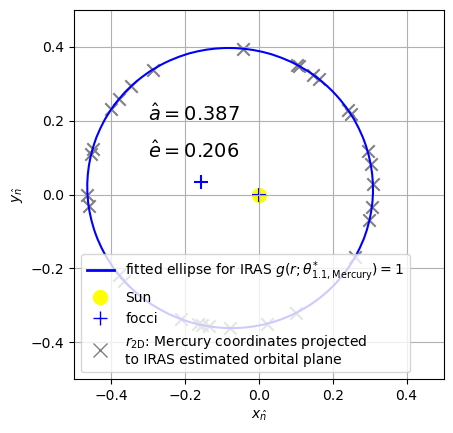

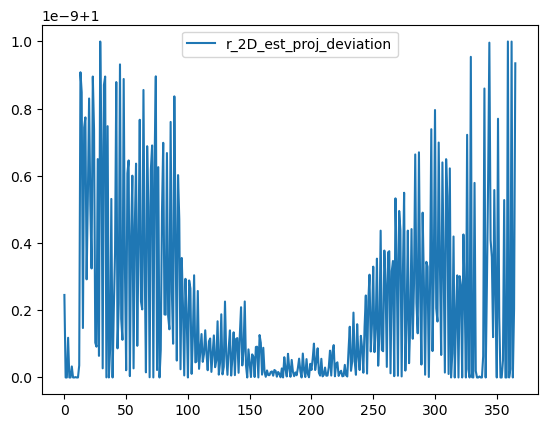

In [12]:
plot_est2D_ellipse(IRAS_runOnCoordinatesResultsDict, 'Mercury', orbitalParams_df, orbitalObs_df, title=r'$g(r; \theta^{*}_{1.1,\mathrm{Mercury}})=1$')

In [13]:
enableIRAS_train = False
if enableIRAS_train:
    IRAS_runOnCoordinatesResultsDict['Mercury2D_v'] = runIRAS('Mercury', true_anomaly_values_df, orbitalObs_df, orbitalParams_df, runOn2D_v=True, externalReport=True)


with open('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/IRAS_results.pkl', 'wb') as file:
    pickle.dump(IRAS_runOnCoordinatesResultsDict, file)

In [14]:
IRAS_runOnCoordinatesResultsDict = pickle.load(open('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/IRAS_results.pkl', 'rb'))
IRAS_runOnCoordinatesResultsDict['Mercury2D_v']['implicitPolyDictList'][0]['ellipse_fit']




{'ellipse_eq': '1252.8462(x - 0.0013)² + -0.0068(x - 0.0013)(y - 0.0057) + 1252.8372(y - 0.0057)²',
 'corr': -0.9110708500452673,
 'ellipse_params': {'A': 1252.8461763468251,
  'B': -0.006824282443533201,
  'C': 1252.837176956323,
  'h': 0.0012805473043526116,
  'k': 0.005666729997624199},
 'ellipse_rot_angle': -0.3243975643818092,
 'axes_eccentricity': {'a': 0.028252239731150066,
  'b': 0.028252112385904953,
  'e': 0.003002475234741978},
 'focci': ((0.0012535098420187749, 0.005586327658100465),
  (0.0013075847666864484, 0.005747132337147933))}

In [15]:
orbitalObs_df['v_2D_est_proj2estEllipse'] = orbitalObs_df.apply(lambda row: project_point_to_ellipse(row, IRAS_runOnCoordinatesResultsDict['Mercury2D_v']['implicitPolyDictList'][0]['ellipse_fit']['ellipse_params'], to_v=True), axis=1)
orbitalObs_df['v_2D_est_sign_x'] = orbitalObs_df.apply(lambda row: replace_y_with_sign(row, IRAS_runOnCoordinatesResultsDict['Mercury2D_v']['implicitPolyDictList'][0]['ellipse_fit']['ellipse_params'], replace_x=True, to_v=True), axis=1)
orbitalObs_df['v_2D_est_sign_x_noisy'] = orbitalObs_df.apply(lambda row: replace_y_with_sign(row, IRAS_runOnCoordinatesResultsDict['Mercury2D_v']['implicitPolyDictList'][0]['ellipse_fit']['ellipse_params'], replace_x=True, to_v=True, noisy=True), axis=1)
orbitalObs_df['L_2D_est_sign'] = orbitalObs_df.apply(lambda row: calc_L(row, twoD=True, est=True, proj2Ellipse=False, sign=True, ellipse_params_r=IRAS_runOnCoordinatesResultsDict['Mercury2D']['implicitPolyDictList'][0]['ellipse_fit']['ellipse_params'], ellipse_params_v=IRAS_runOnCoordinatesResultsDict['Mercury2D_v']['implicitPolyDictList'][0]['ellipse_fit']['ellipse_params']), axis=1)
orbitalObs_df['L_2D_est_sign_noisy'] = orbitalObs_df.apply(lambda row: calc_L(row, twoD=True, est=True, proj2Ellipse=False, sign=True, noisy=True, ellipse_params_r=IRAS_runOnCoordinatesResultsDict['Mercury2D']['implicitPolyDictList'][0]['ellipse_fit']['ellipse_params'], ellipse_params_v=IRAS_runOnCoordinatesResultsDict['Mercury2D_v']['implicitPolyDictList'][0]['ellipse_fit']['ellipse_params']), axis=1)

Pearson correlation between g() and estimated ellipse is 0.911


/Users/ron.teichner/Projects/IRAS/kepler_func.py:660: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(X, Y, Z, levels=[1], colors='blue', label='fitted ellipse for IRAS g()')


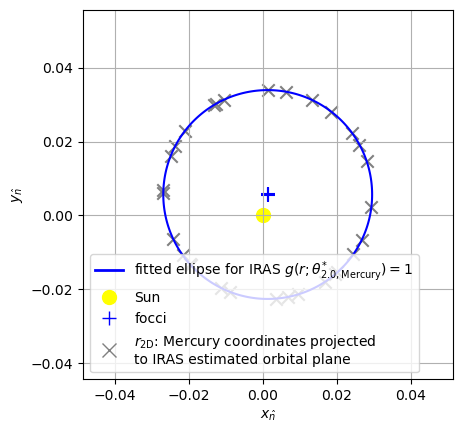

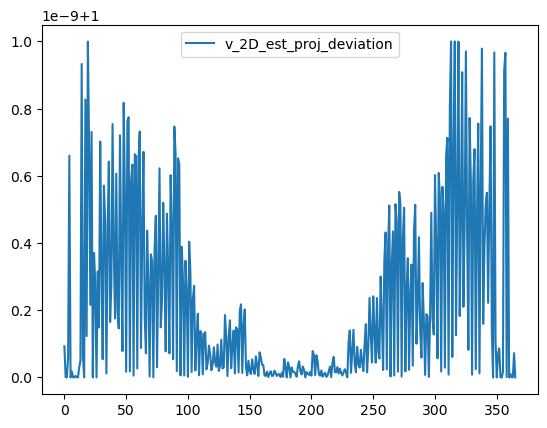

In [16]:
plot_est2D_ellipse(IRAS_runOnCoordinatesResultsDict, 'Mercury', orbitalParams_df, orbitalObs_df, to_v=True, title=r'$g(r; \theta^{*}_{2.0,\mathrm{Mercury}})=1$')

In [17]:
alpha = 1e-2
orbitalObs_df['r_2D_est_proj2estEllipse_noisy'] = orbitalObs_df.apply(lambda row: convert_to_r(row, orbitalObs_df, orbitalParams_df, alpha, workOn2D_Proj=True, to_v=False, est=True), axis=1)
orbitalObs_df['v_2D_est_proj2estEllipse_noisy'] = orbitalObs_df.apply(lambda row: convert_to_r(row, orbitalObs_df, orbitalParams_df, alpha, workOn2D_Proj=True, to_v=True, est=True), axis=1)
orbitalObs_df['L_2D_est_proj2estEllipse'] = orbitalObs_df.apply(lambda row: calc_L(row, twoD=True, est=True, proj2Ellipse=True), axis=1)
orbitalObs_df['L_2D_est_proj2estEllipse_noisy'] = orbitalObs_df.apply(lambda row: calc_L(row, twoD=True, est=True, noisy=True, proj2Ellipse=True), axis=1)

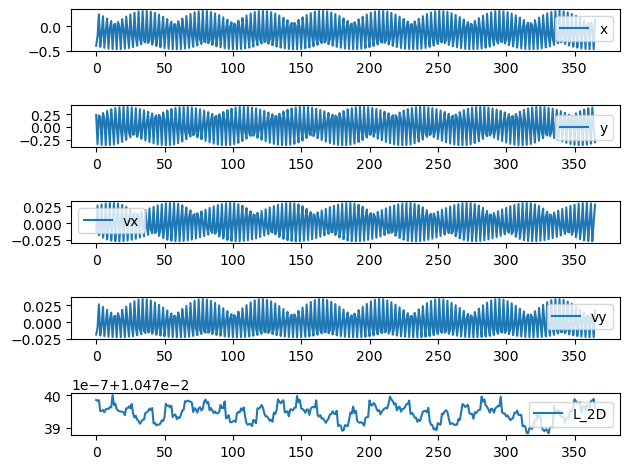

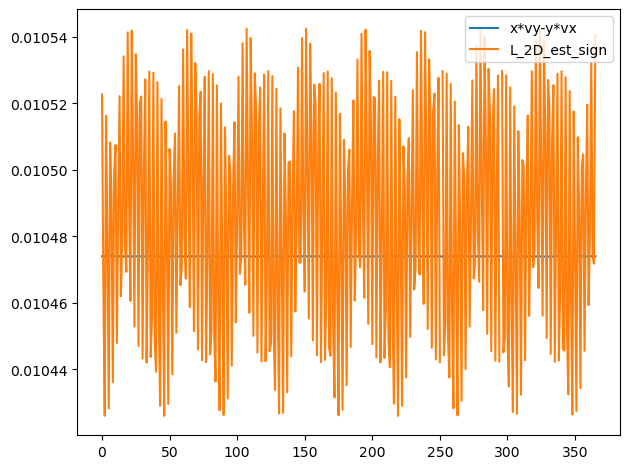

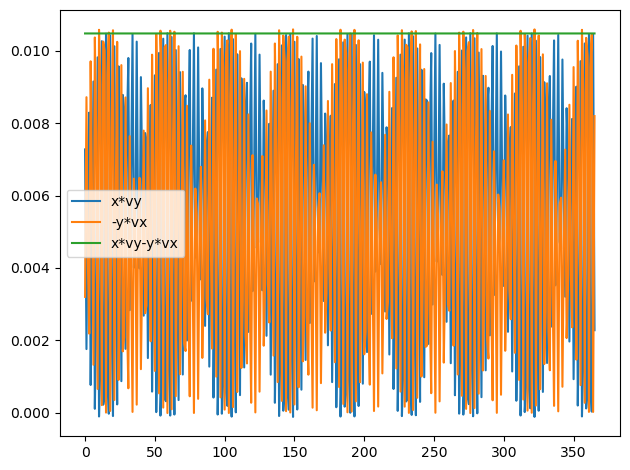

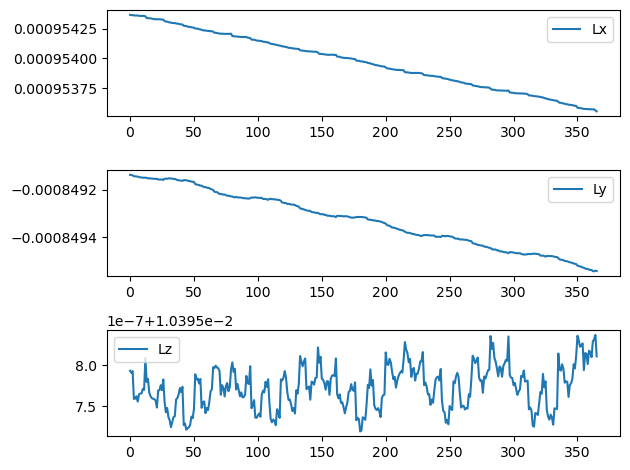

In [18]:
Obs = orbitalObs_df[orbitalObs_df['target'] == 'Mercury']

#x = np.asarray([Obs['r_2D_est_proj2estEllipse'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
#y = np.asarray([Obs['r_2D_est_proj2estEllipse'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])
#vx = np.asarray([Obs['v_2D_est_proj2estEllipse'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
#vy = np.asarray([Obs['v_2D_est_proj2estEllipse'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])
#L_2D_est_proj2estEllipse = np.asarray([Obs['L_2D_est_proj2estEllipse'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
#L_2D_est_proj2estEllipse_noisy = np.asarray([Obs['L_2D_est_proj2estEllipse_noisy'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])

x = np.asarray([Obs['r_2D'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
y = np.asarray([Obs['r_2D'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])
vx = np.asarray([Obs['v_2D'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
vy = np.asarray([Obs['v_2D'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])
L_2D = np.asarray([Obs['L_2D'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
L_2D_noisy = np.asarray([Obs['L_2D_noisy'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
L_2D_est_sign = np.asarray([Obs['L_2D_est_sign'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])


plt.figure()
plt.subplot(5,1,1)
plt.plot(x, label='x')
plt.legend()
plt.subplot(5,1,2)
plt.plot(y, label='y')
plt.legend()
plt.subplot(5,1,3)
plt.plot(vx, label='vx')
plt.legend()
plt.subplot(5,1,4)
plt.plot(vy, label='vy')
plt.legend()
plt.subplot(5,1,5)
plt.plot(L_2D, label='L_2D')
#plt.plot(L_2D_est_proj2estEllipse_noisy, label='L_2D_est_proj2estEllipse_noisy')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
#plt.plot(x*vy, label='x*vy')
#plt.plot(-y*vx, label='-y*vx')
plt.plot(x*vy-y*vx, label='x*vy-y*vx')
plt.plot(L_2D_est_sign, label='L_2D_est_sign')
#plt.plot(x*vy+y*vx, label='x*vy+y*vx')
plt.legend()
plt.tight_layout()
plt.show()


plt.figure()
plt.plot(x*vy, label='x*vy')
plt.plot(-y*vx, label='-y*vx')
plt.plot(x*vy-y*vx, label='x*vy-y*vx')
#plt.plot(x*vy+y*vx, label='x*vy+y*vx')
plt.legend()
plt.tight_layout()
plt.show()


Lx = np.asarray([Obs['L'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
Ly = np.asarray([Obs['L'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])
Lz = np.asarray([Obs['L'].to_numpy()[i][2,0] for i in range(Obs.shape[0])])

plt.figure()
plt.subplot(3,1,1)
plt.plot(Lx, label='Lx')
plt.legend()
plt.subplot(3,1,2)
plt.plot(Ly, label='Ly')
plt.legend()
plt.subplot(3,1,3)
plt.plot(Lz, label='Lz')
plt.legend()
plt.tight_layout()
plt.show()



In [19]:
enableIRAS_train = True
if enableIRAS_train:
    IRAS_runOnCoordinatesResultsDict['Mercury_2DK2'] = runIRAS('Mercury', true_anomaly_values_df, orbitalObs_df, orbitalParams_df, runCoordinates_n_Velocities=True, externalReport=True)
    #IRAS_runOnCoordinatesResultsDict['Planets_2DK2'] = runIRAS(list(planets.keys()), true_anomaly_values_df, orbitalObs_df, orbitalParams_df, runCoordinates_n_Velocities=True, externalReport=True)


with open('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/IRAS_results.pkl', 'wb') as file:
    pickle.dump(IRAS_runOnCoordinatesResultsDict, file)


KeyboardInterrupt: 

In [20]:
IRAS_runOnCoordinatesResultsDict = pickle.load(open('/Users/ron.teichner/Library/CloudStorage/OneDrive-Technion/Kepler/IRAS_results.pkl', 'rb'))

highScoreHyp = get_highScoreHyp(IRAS_runOnCoordinatesResultsDict['Mercury_2DK2'])
print_IRAS_res(IRAS_runOnCoordinatesResultsDict['Mercury_2DK2'], highScoreHyp)

TypeError: 'NoneType' object is not subscriptable

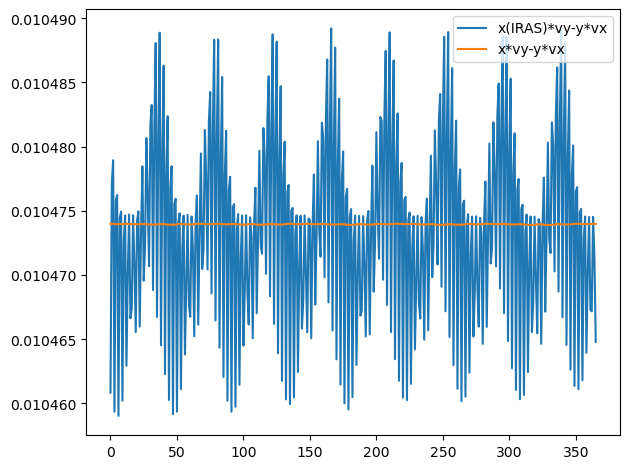

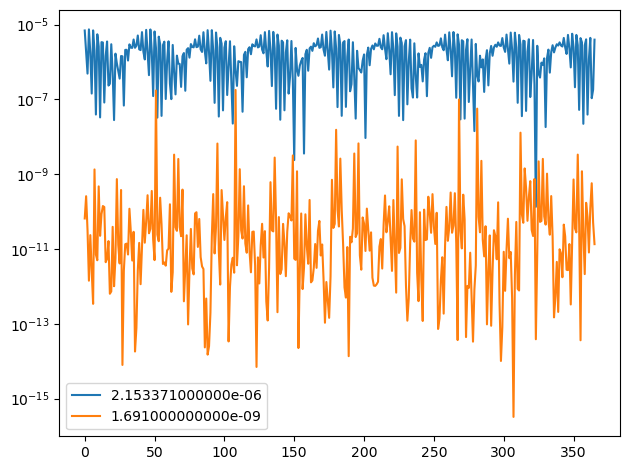

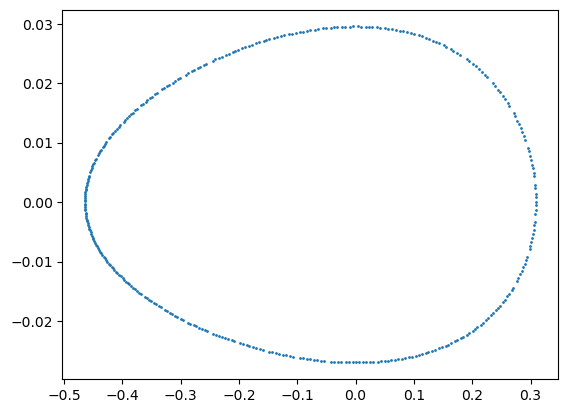

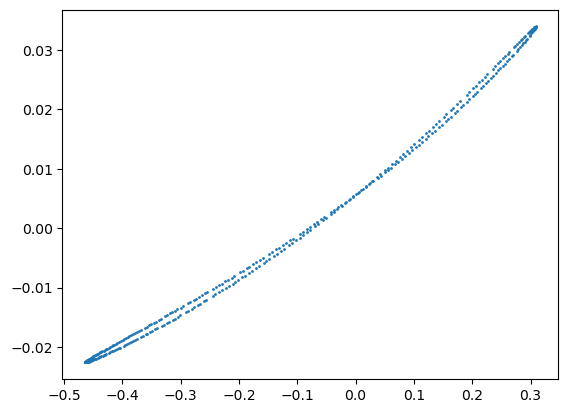

In [23]:
x = np.asarray([Obs['r_2D'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
y = np.asarray([Obs['r_2D'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])
vx = np.asarray([Obs['v_2D'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
vy = np.asarray([Obs['v_2D'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])

L_2D = np.asarray([Obs['L_2D'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])


implicitPolyDict = IRAS_runOnCoordinatesResultsDict['Mercury_2DK2']['implicitPolyDictList'][get_highScoreHyp(IRAS_runOnCoordinatesResultsDict['Mercury_2DK2'])]
x_IRAS_solutions_list = [solve_for_x0(implicitPolyDict['coefficients'], implicitPolyDict['intercept'], *row) for row in zip(y,vx,vy,0*np.mean(L_2D)*np.ones(len(x)))]
x_angularMomentumSol = (np.mean(L_2D) + y*vx)/vy

x_IRAS_solutions_list = [l[np.argmin(np.abs(np.asarray(l)-xs))] for l,xs in zip(x_IRAS_solutions_list,x)]

plt.figure()
plt.plot(x_IRAS_solutions_list*vy-y*vx, label='x(IRAS)*vy-y*vx')
plt.plot(x*vy-y*vx, label='x*vy-y*vx')
plt.legend()
plt.tight_layout()
plt.show()


x_error_IRAS = x - x_IRAS_solutions_list
x_error_angular = x - x_angularMomentumSol

plt.figure()
formattedIRAS = f"{round(np.var(x_error_IRAS) / np.var(x), 12):.12e}"
formattedAngular = f"{round(np.var(x_error_angular) / np.var(x), 12):.12e}"
plt.plot(x_error_IRAS**2 / np.var(x), label=formattedIRAS)
plt.plot(x_error_angular**2 / np.var(x), label=formattedAngular)
plt.legend()
plt.yscale('log')
plt.tight_layout()
plt.show()

plt.figure()
plt.scatter(x,vx,s=1)
plt.xlabel = 'x'
plt.ylabel = 'vx'
plt.show()

plt.figure()
plt.scatter(x,vy,s=1)
plt.xlabel = 'x'
plt.ylabel = 'vy'
plt.show()


In [23]:
x_IRAS_solutions_list = [l[np.argmin(np.abs(np.asarray(l)-xs))] for l,xs in zip(x_IRAS_solutions_list,x)]

x_IRAS_solutions_list

[-0.40011482852345315,
 -0.21061935489207276,
 0.24922137870867128,
 -0.4249214110068614,
 -0.1542499115244641,
 0.20665933258528224,
 -0.444306736086834,
 -0.09404953929675776,
 0.15839095499268308,
 -0.4581894840371833,
 -0.03166074938859988,
 0.10630472787177309,
 -0.4665752527533802,
 0.030878611034435108,
 0.05197725476575342,
 -0.46952595255613716,
 0.09145831470096338,
 -0.0033474571427382334,
 -0.46712279738394924,
 0.148218238129821,
 -0.058579377021182016,
 -0.4594135617419923,
 0.1997571131461684,
 -0.11279997824931189,
 -0.4464021427606536,
 0.2447641092546349,
 -0.16519858386523426,
 -0.42802019400665514,
 0.2814008260632821,
 -0.21506675141777426,
 -0.40414720195412557,
 0.3072297206879682,
 -0.2617647018959917,
 -0.3746150159170175,
 0.32001389801131586,
 -0.3047036125409571,
 -0.33925433744508854,
 0.3187025849390508,
 -0.34336074166523894,
 -0.2979765919651449,
 0.30376528958566645,
 -0.3773038015630706,
 -0.2508576651859738,
 0.2768533308509725,
 -0.40619746546412444,

In [16]:
# IRAS_train_script(observations, observations_tVec, hypotheses_regulations, titleStr='', nativeIRAS=True)
# with observations having shape of (N x T x F) and observations_tVec (N x T x 1). 
# Here N is the number of observed timeseries, T is the number of samples in each timeseries and F the number of observables. 
# The observations are in the variable observations and their corresponding times in observations_tVec. 
# In the input V the user can place an hypothesis. 
# The Pearson correlation between the hypothesis and the output of the algorithm is printed and their figure is plotted.
#   playerPerPatient = False

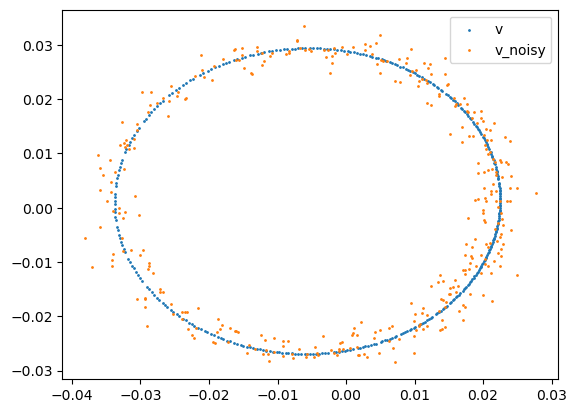

In [17]:
Obs = orbitalObs_df[orbitalObs_df['target'] == 'Mercury']

vx = np.asarray([Obs['v'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
vy = np.asarray([Obs['v'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])

vx_n = np.asarray([Obs['vNoisy'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
vy_n = np.asarray([Obs['vNoisy'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])

plt.figure()
plt.scatter(x=vx, y=vy, s=1, label='v')
plt.scatter(x=vx_n, y=vy_n, s=1, label='v_noisy')
plt.legend()
plt.show()


In [18]:
Obs.columns

Index(['target', 'datetime_jd', 'datetime_str', 'x', 'y', 'z', 'vx', 'vy',
       'vz', 'lighttime', 'range', 'range_rate', 'r', 'r_proj2OrbitalPlane',
       'r_2D', 'v', 'v_proj2OrbitalPlane', 'v_2D', 'L', 'L_2D', 'rNoisy',
       'vNoisy', 'L_Noisy', 'r_tag', 'r_tagNoisy', 'r_proj2EstOrbitalPlane',
       'r_2D_est', 'r_2D_est_noisy', 'v_proj2EstOrbitalPlane', 'v_2D_est',
       'v_2D_est_noisy', 'L_2D_est', 'L_2D_est_noisy'],
      dtype='object')

In [19]:
Obs = orbitalObs_df[orbitalObs_df['target'] == 'Mercury']

In [20]:
Obs.columns

Index(['target', 'datetime_jd', 'datetime_str', 'x', 'y', 'z', 'vx', 'vy',
       'vz', 'lighttime', 'range', 'range_rate', 'r', 'r_proj2OrbitalPlane',
       'r_2D', 'v', 'v_proj2OrbitalPlane', 'v_2D', 'L', 'L_2D', 'rNoisy',
       'vNoisy', 'L_Noisy', 'r_tag', 'r_tagNoisy', 'r_proj2EstOrbitalPlane',
       'r_2D_est', 'r_2D_est_noisy', 'v_proj2EstOrbitalPlane', 'v_2D_est',
       'v_2D_est_noisy', 'L_2D_est', 'L_2D_est_noisy'],
      dtype='object')

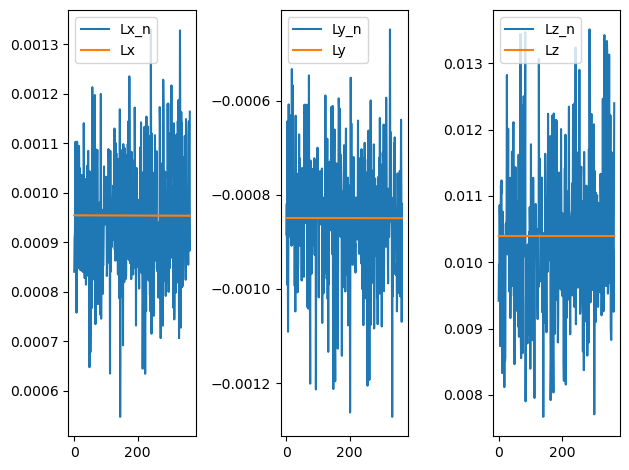

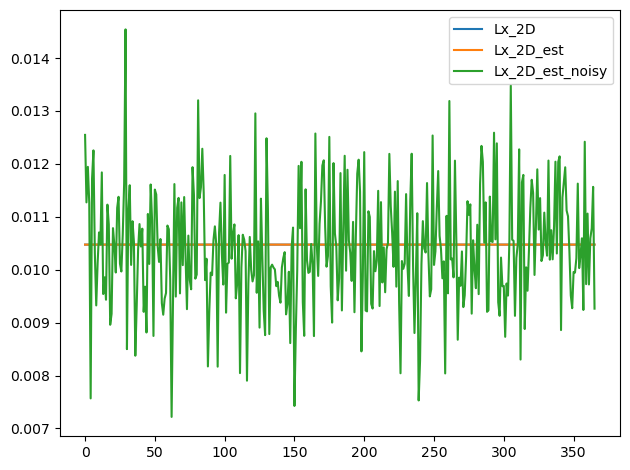

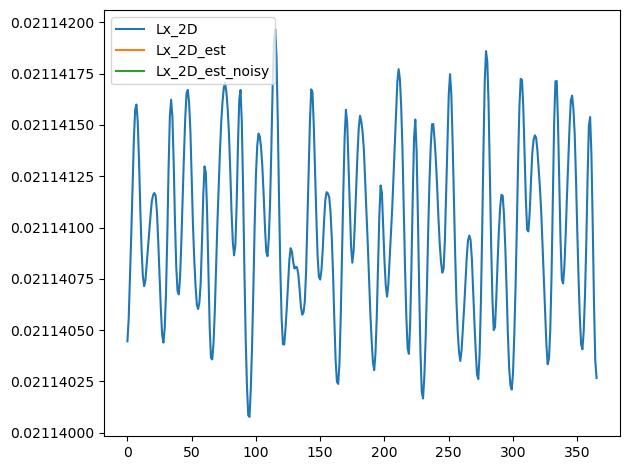

In [21]:
Obs = orbitalObs_df[orbitalObs_df['target'] == 'Mercury']
Lx = np.asarray([Obs['L'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
Ly = np.asarray([Obs['L'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])
Lz = np.asarray([Obs['L'].to_numpy()[i][2,0] for i in range(Obs.shape[0])])

Lx_n = np.asarray([Obs['L_Noisy'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
Ly_n = np.asarray([Obs['L_Noisy'].to_numpy()[i][1,0] for i in range(Obs.shape[0])])
Lz_n = np.asarray([Obs['L_Noisy'].to_numpy()[i][2,0] for i in range(Obs.shape[0])])


plt.figure()
plt.subplot(1,3,1)
plt.plot(Lx_n, label='Lx_n')
plt.plot(Lx, label='Lx')
plt.legend()

plt.subplot(1,3,2)
plt.plot(Ly_n, label='Ly_n')
plt.plot(Ly, label='Ly')
plt.legend()

plt.subplot(1,3,3)
plt.plot(Lz_n, label='Lz_n')
plt.plot(Lz, label='Lz')
plt.legend()

plt.tight_layout()
plt.show()
############
Lx_2D = np.asarray([Obs['L_2D'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
Lx_2D_est = np.asarray([Obs['L_2D_est'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
Lx_2D_est_noisy = np.asarray([Obs['L_2D_est_noisy'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])


plt.figure()
#plt.plot(Lx_n, label='Lx_n')
plt.plot(Lx_2D, label='Lx_2D')
plt.plot(Lx_2D_est, label='Lx_2D_est')
plt.plot(Lx_2D_est_noisy, label='Lx_2D_est_noisy')
plt.legend()

plt.tight_layout()
plt.show()

Obs = orbitalObs_df[orbitalObs_df['target'] == 'Mars']
Lx_2D = np.asarray([Obs['L_2D'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
Lx_2D_est = np.asarray([Obs['L_2D_est'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])
Lx_2D_est_noisy = np.asarray([Obs['L_2D_est_noisy'].to_numpy()[i][0,0] for i in range(Obs.shape[0])])

plt.figure()
#plt.plot(Lx_n, label='Lx_n')
plt.plot(Lx_2D, label='Lx_2D')
plt.plot(Lx_2D_est, label='Lx_2D_est')
plt.plot(Lx_2D_est_noisy, label='Lx_2D_est_noisy')
plt.legend()

plt.tight_layout()
plt.show()